In [1]:
# 한번씩 실행해서 neo4j 패키지 설치해주세요
# !python -m pip install neo4j

# Schema 디자인

LIKE는 likeness라는 속성으로서 '좋아하는 정도'를 내포하고 있습니다.

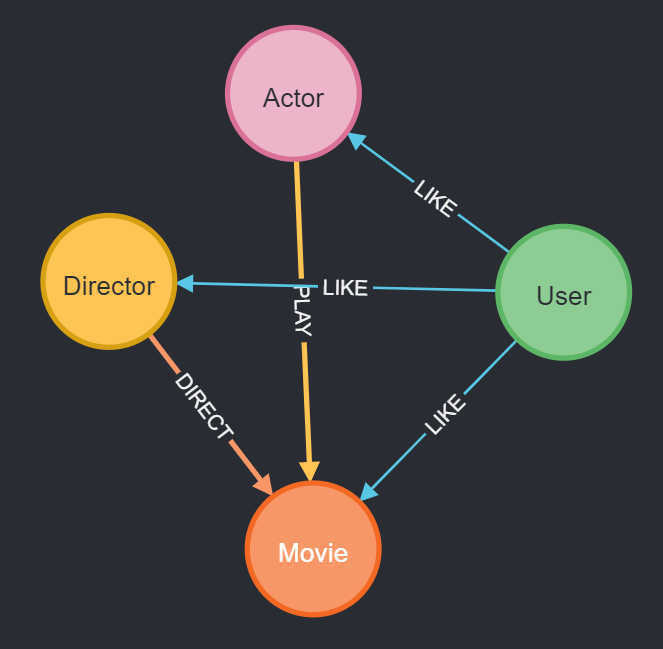

In [2]:
from IPython.display import Image
Image("schema.png")

# 실행 시, neo4j 전반적인 형태

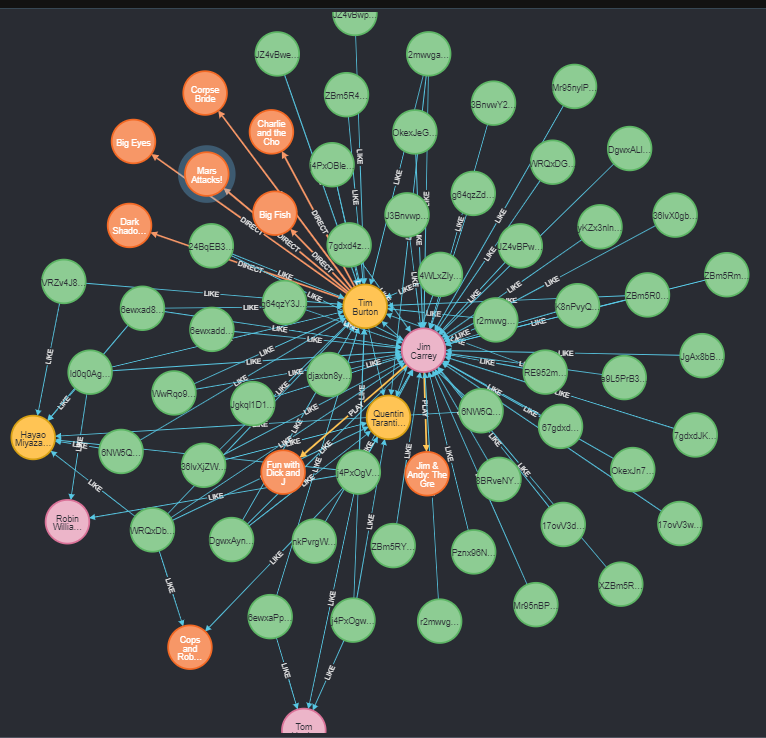

In [3]:
Image('graph.png')

# 기본 setting

In [4]:
# 성우 파일 동일
import pandas as pd
from json import dumps
import logging
import os

from flask import (
    Flask,
    g,
    request,
    Response,
)
from neo4j import (
    GraphDatabase,
    basic_auth,
)

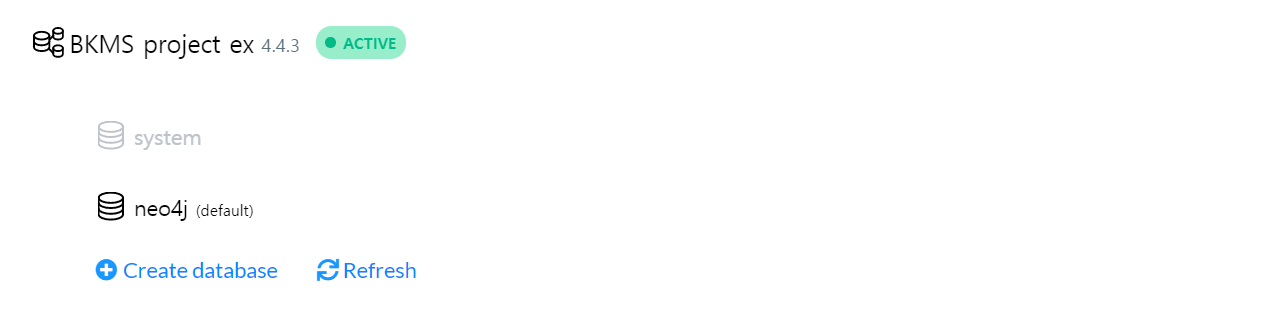

In [5]:
Image("setting.png")

여기서 조심할 점 : 로컬로 neo4j를 반드시 미리 켜 놓아야 한다. (start까지 실행할 것)

In [6]:
# 성우 파일 동일 : 아래 코드는 비밀번호말고 전혀 수정할 내용 없음
scheme = "bolt" 
host_name = "localhost"
port = 7687
url = f"{scheme}://{host_name}:{port}"
user = "neo4j"

# 지금 내가 실행한 DB의 비밀번호를 입력해주자.
password = "1234"

driver = GraphDatabase.driver(url, auth=(user, password))
driver.verify_connectivity()

C:\Users\user\AppData\Local\Temp\ipykernel_23896\3945219970.py:12: ExperimentalWarning: The configuration may change in the future.
  driver.verify_connectivity()


'Neo4j/4.4.3'

In [7]:
# 성우 파일 동일
driver.session(database="neo4j") # 지금 start시킨 database 이름

# Neo4j CQL : create nodes and relations

## 간단한 형식 조정

먼저 크롤링한 전체 csv 파일을 불러와 필요한 전처리를 수행하자.

In [8]:
# 각자 csv 파일을 보관하고 있는 경로에 맞게 설정 필요

# 전체 데이터셋을 처리하고자 한다면, 아래 코드 실행 : 크롤링 데이터 merging
db1 = pd.read_csv("user_info_1_201.csv")
db2 = pd.read_csv("user_info_200_450.csv")
# db3 = pd.read_csv("경로\\user_info_450_700.csv")
db4_1 = pd.read_csv("user_info_700_800.csv")
db4_2 = pd.read_csv("user_info_800_950.csv")
# db5 = pd.read_csv("경로\\user_info_950_1200.csv")
db6 = pd.read_csv("user_info_1200_1410.csv")
db = pd.concat([db1,db2,db4_1,db4_2,db6], axis = 0)
db = db.reset_index()

id_info = pd.read_csv("merged.csv")

In [9]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5321 entries, 0 to 5320
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               5321 non-null   int64 
 1   watcha_movie_id     5321 non-null   object
 2   user_id             5321 non-null   object
 3   rating              5321 non-null   object
 4   Favorite_Actors     5303 non-null   object
 5   Favorite_Directors  5304 non-null   object
 6   Favorite_Genres     5320 non-null   object
dtypes: int64(1), object(6)
memory usage: 291.1+ KB


상기 데이터프레임 형식을 보면, object 형식으로 각 데이터가 컬럼에 저장되어 있다. 적절한 type으로 casting 해주자. <br> 그런데 rating 중 가끔 string으로 요상한 값들이 끼어있다. 이 경우, 해당 row data는 날려주겠다.

In [10]:
# Rating column 전처리 & nan 결측값 제거
# 여기서 nan 값 제거 안하면, 추후 삽입 과정에서 오류 발생
weird_rows = []
for i in range(db.shape[0]):
    try:
        db['rating'][i] = float(db['rating'][i])
    except:
        print("As there's a weird value in 'rating' column, the corresponding row data should be deleted.")
        print(f"Row index : {i}")
        weird_rows.append(i)
        print("=====================================================================================")

db = db.iloc[list(set(range(db.shape[0]))-set(weird_rows)), :]
db['rating'] = pd.to_numeric(db['rating'])
db = db.dropna()
db = db.reset_index()
db = db.iloc[:,2:]

C:\Users\user\AppData\Local\Temp\ipykernel_23896\276354167.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['rating'][i] = float(db['rating'][i])


As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 420
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 659
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 805
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 838
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 1050
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 1209
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 1300
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 1449
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 1451
As there's a weird value in 'rat

As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4245
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4253
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4273
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4280
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4282
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4511
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4559
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4578
As there's a weird value in 'rating' column, the corresponding row data should be deleted.
Row index : 4749
As there's a weird value in 

C:\Users\user\AppData\Local\Temp\ipykernel_23896\276354167.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['rating'] = pd.to_numeric(db['rating'])


## CREATE movie, user, actor, director nodes

In [11]:
# for API
genre_dict_API = {1:"Biography",
2:"Film Noir",
3:"Game Show",
4:"Musical",
5:"Sport",
6:"Short",
7:"Adult",
12:"Adventure",
14:"Fantasy",
16:"Animation",
18:"Drama",
27:"Horror",
28:"Action",
35:"Comedy",
36:"History",
37:"Western",
53:"Thriller",
80:"Crime",
99:"Documentary",
878:"Science Fiction",
9648:"Mystery",
10402:"Music",
10749:"Romance",
10751:"Family",
10752:"War",
10763:"News",
10764:"Reality",
10767:"Talk Show"}

쿼리는 다음과 같이 구현했다.

In [12]:
# Query implementation : Part 1

with driver.session(database="neo4j") as session:
    def create_movie(tx, movie_watchaID, movie_year, movie_runtime, movie_title, movie_genre, movie_countries, movie_age, movie_lan):
        query = (
            "CREATE (m1:Movie { id: $movie_watchaID, year: $movie_year, runtime: $movie_runtime, title: $movie_title, genre : $movie_genre, countries : $movie_countries ,age : $movie_age, original_lan : $movie_lan}) "
            "RETURN m1"
        )
        result = tx.run(query, movie_watchaID=movie_watchaID, movie_year=movie_year, movie_runtime=movie_runtime, movie_title=movie_title, movie_genre=movie_genre, movie_countries=movie_countries, movie_age=movie_age, movie_lan=movie_lan)
        return [{"m1": record["m1"]["movie_title"]} for record in result]
    
    visited = {}
    for i in range(id_info.shape[0]):
        movie_watchaID = str(id_info.loc[i, "watcha_movie_id"])
        visited[movie_watchaID] = 0
        
    for i in range(id_info.shape[0]):
        movie_watchaID = str(id_info.loc[i, "watcha_movie_id"])
        visited[movie_watchaID] += 1
        if visited[movie_watchaID] == 1:
            movie_year = str(id_info.loc[i, "year"])
            movie_runtime = str(id_info.loc[i, "runtime"])
            movie_title = id_info.loc[i, "title"]
            movie_genre = genre_dict_API[eval(id_info.loc[i, "genres"])[0]]
            try:
                movie_countries = eval(id_info.loc[i, "countries"])[0]
            except:
                movie_countries = 'None'
            movie_age = str(id_info.loc[i, "age"])
            movie_lan = id_info.loc[i, "originalLanguage"]
            result = session.write_transaction(create_movie, movie_watchaID=movie_watchaID, movie_year=movie_year, movie_runtime=movie_runtime, movie_title=movie_title, movie_genre=movie_genre, movie_countries=movie_countries, movie_age=movie_age, movie_lan=movie_lan)
            print(f"{i}th iteration")
    print("Finished")

0th iteration
1th iteration
2th iteration
3th iteration
4th iteration
5th iteration
6th iteration
7th iteration
8th iteration
9th iteration
10th iteration
11th iteration
12th iteration
13th iteration
14th iteration
15th iteration
16th iteration
17th iteration
18th iteration
19th iteration
20th iteration
21th iteration
22th iteration
23th iteration
24th iteration
25th iteration
26th iteration
27th iteration
28th iteration
29th iteration
30th iteration
31th iteration
32th iteration
33th iteration
34th iteration
35th iteration
36th iteration
37th iteration
38th iteration
39th iteration
40th iteration
41th iteration
42th iteration
43th iteration
44th iteration
45th iteration
46th iteration
47th iteration
48th iteration
49th iteration
50th iteration
51th iteration
52th iteration
53th iteration
54th iteration
55th iteration
56th iteration
57th iteration
58th iteration
59th iteration
60th iteration
61th iteration
62th iteration
63th iteration
64th iteration
65th iteration
66th iteration
67th 

541th iteration
542th iteration
543th iteration
544th iteration
545th iteration
546th iteration
547th iteration
548th iteration
549th iteration
550th iteration
551th iteration
552th iteration
553th iteration
554th iteration
555th iteration
556th iteration
557th iteration
558th iteration
559th iteration
560th iteration
561th iteration
562th iteration
563th iteration
564th iteration
565th iteration
566th iteration
567th iteration
568th iteration
569th iteration
570th iteration
571th iteration
572th iteration
573th iteration
574th iteration
575th iteration
576th iteration
577th iteration
578th iteration
579th iteration
580th iteration
581th iteration
582th iteration
583th iteration
584th iteration
585th iteration
586th iteration
587th iteration
588th iteration
589th iteration
590th iteration
591th iteration
592th iteration
593th iteration
594th iteration
595th iteration
596th iteration
597th iteration
598th iteration
599th iteration
600th iteration
601th iteration
602th iteration
603th it

1054th iteration
1055th iteration
1056th iteration
1057th iteration
1058th iteration
1059th iteration
1060th iteration
1061th iteration
1062th iteration
1063th iteration
1064th iteration
1065th iteration
1066th iteration
1067th iteration
1068th iteration
1069th iteration
1070th iteration
1071th iteration
1072th iteration
1073th iteration
1074th iteration
1075th iteration
1076th iteration
1077th iteration
1078th iteration
1079th iteration
1080th iteration
1081th iteration
1082th iteration
1083th iteration
1084th iteration
1085th iteration
1086th iteration
1087th iteration
1088th iteration
1089th iteration
1090th iteration
1091th iteration
1092th iteration
1093th iteration
1094th iteration
1095th iteration
1096th iteration
1097th iteration
1098th iteration
1099th iteration
1100th iteration
1101th iteration
1102th iteration
1103th iteration
1104th iteration
1105th iteration
1106th iteration
1107th iteration
1108th iteration
1109th iteration
1110th iteration
1111th iteration
1112th iterati

In [13]:
# Query implementation : Part 2

with driver.session(database="neo4j") as session:
    def create_user(tx, movie_watchaID, user_watchaID, like_movie):
        query = (
            "MATCH (m1:Movie { id: $movie_watchaID }) "
            "CREATE (u1:User { id: $user_watchaID }) "
            "CREATE (u1)-[:LIKE {Likeness: $like_movie}]->(m1) "
            "RETURN m1, u1"
        )
        result = tx.run(query, movie_watchaID=movie_watchaID, user_watchaID=user_watchaID, like_movie=like_movie)
        return [{"m1": record["m1"]["movie_title"]} for record in result]
    
    visited = {}
    for i in range(db.shape[0]):
        user_watchaID = str(db.loc[i, "user_id"])
        visited[user_watchaID] = 0
    for i in range(db.shape[0]):
        movie_watchaID = str(db.loc[i, "watcha_movie_id"])
        user_watchaID = str(db.loc[i, "user_id"])
        like_movie = str(db.loc[i, "rating"])
        visited[user_watchaID] += 1
        if visited[user_watchaID] == 1:
            result = session.write_transaction(create_user, movie_watchaID=movie_watchaID, user_watchaID=user_watchaID, like_movie=like_movie)
            print(f"=========== {i}th iteration ===========")
    print('FINISHED')

=========== 0th iteration ===========
=========== 1th iteration ===========
=========== 2th iteration ===========
=========== 3th iteration ===========
=========== 4th iteration ===========
=========== 5th iteration ===========
=========== 6th iteration ===========
=========== 7th iteration ===========
=========== 8th iteration ===========
=========== 9th iteration ===========
=========== 10th iteration ===========
=========== 11th iteration ===========
=========== 12th iteration ===========
=========== 13th iteration ===========
=========== 14th iteration ===========
=========== 15th iteration ===========
=========== 16th iteration ===========
=========== 17th iteration ===========
=========== 19th iteration ===========
=========== 20th iteration ===========
=========== 23th iteration ===========
=========== 24th iteration ===========
=========== 25th iteration ===========
=========== 26th iteration ===========
=========== 27th iteration ===========
=========== 28th iteration ========

=========== 318th iteration ===========
=========== 319th iteration ===========
=========== 322th iteration ===========
=========== 323th iteration ===========
=========== 324th iteration ===========
=========== 325th iteration ===========
=========== 326th iteration ===========
=========== 330th iteration ===========
=========== 333th iteration ===========
=========== 334th iteration ===========
=========== 335th iteration ===========
=========== 336th iteration ===========
=========== 337th iteration ===========
=========== 338th iteration ===========
=========== 339th iteration ===========
=========== 340th iteration ===========
=========== 341th iteration ===========
=========== 342th iteration ===========
=========== 343th iteration ===========
=========== 345th iteration ===========
=========== 347th iteration ===========
=========== 349th iteration ===========
=========== 350th iteration ===========
=========== 352th iteration ===========
=========== 357th iteration ===========


=========== 743th iteration ===========
=========== 744th iteration ===========
=========== 746th iteration ===========
=========== 748th iteration ===========
=========== 749th iteration ===========
=========== 750th iteration ===========
=========== 751th iteration ===========
=========== 752th iteration ===========
=========== 756th iteration ===========
=========== 757th iteration ===========
=========== 758th iteration ===========
=========== 759th iteration ===========
=========== 760th iteration ===========
=========== 762th iteration ===========
=========== 763th iteration ===========
=========== 769th iteration ===========
=========== 775th iteration ===========
=========== 776th iteration ===========
=========== 784th iteration ===========
=========== 785th iteration ===========
=========== 786th iteration ===========
=========== 787th iteration ===========
=========== 788th iteration ===========
=========== 793th iteration ===========
=========== 794th iteration ===========


=========== 1283th iteration ===========
=========== 1287th iteration ===========
=========== 1288th iteration ===========
=========== 1290th iteration ===========
=========== 1293th iteration ===========
=========== 1296th iteration ===========
=========== 1297th iteration ===========
=========== 1298th iteration ===========
=========== 1299th iteration ===========
=========== 1300th iteration ===========
=========== 1303th iteration ===========
=========== 1305th iteration ===========
=========== 1307th iteration ===========
=========== 1310th iteration ===========
=========== 1311th iteration ===========
=========== 1312th iteration ===========
=========== 1313th iteration ===========
=========== 1314th iteration ===========
=========== 1316th iteration ===========
=========== 1317th iteration ===========
=========== 1318th iteration ===========
=========== 1325th iteration ===========
=========== 1326th iteration ===========
=========== 1330th iteration ===========
=========== 1332

=========== 1838th iteration ===========
=========== 1843th iteration ===========
=========== 1844th iteration ===========
=========== 1846th iteration ===========
=========== 1847th iteration ===========
=========== 1850th iteration ===========
=========== 1854th iteration ===========
=========== 1855th iteration ===========
=========== 1857th iteration ===========
=========== 1858th iteration ===========
=========== 1861th iteration ===========
=========== 1862th iteration ===========
=========== 1865th iteration ===========
=========== 1866th iteration ===========
=========== 1869th iteration ===========
=========== 1872th iteration ===========
=========== 1873th iteration ===========
=========== 1874th iteration ===========
=========== 1875th iteration ===========
=========== 1876th iteration ===========
=========== 1878th iteration ===========
=========== 1879th iteration ===========
=========== 1881th iteration ===========
=========== 1882th iteration ===========
=========== 1886

=========== 2468th iteration ===========
=========== 2470th iteration ===========
=========== 2471th iteration ===========
=========== 2474th iteration ===========
=========== 2475th iteration ===========
=========== 2476th iteration ===========
=========== 2477th iteration ===========
=========== 2478th iteration ===========
=========== 2483th iteration ===========
=========== 2484th iteration ===========
=========== 2485th iteration ===========
=========== 2492th iteration ===========
=========== 2494th iteration ===========
=========== 2495th iteration ===========
=========== 2496th iteration ===========
=========== 2497th iteration ===========
=========== 2498th iteration ===========
=========== 2499th iteration ===========
=========== 2500th iteration ===========
=========== 2501th iteration ===========
=========== 2502th iteration ===========
=========== 2503th iteration ===========
=========== 2504th iteration ===========
=========== 2509th iteration ===========
=========== 2511

=========== 3253th iteration ===========
=========== 3267th iteration ===========
=========== 3268th iteration ===========
=========== 3269th iteration ===========
=========== 3276th iteration ===========
=========== 3277th iteration ===========
=========== 3278th iteration ===========
=========== 3280th iteration ===========
=========== 3281th iteration ===========
=========== 3282th iteration ===========
=========== 3283th iteration ===========
=========== 3285th iteration ===========
=========== 3289th iteration ===========
=========== 3290th iteration ===========
=========== 3297th iteration ===========
=========== 3298th iteration ===========
=========== 3299th iteration ===========
=========== 3316th iteration ===========
=========== 3317th iteration ===========
=========== 3318th iteration ===========
=========== 3319th iteration ===========
=========== 3320th iteration ===========
=========== 3324th iteration ===========
=========== 3325th iteration ===========
=========== 3329

=========== 3801th iteration ===========
=========== 3802th iteration ===========
=========== 3803th iteration ===========
=========== 3804th iteration ===========
=========== 3806th iteration ===========
=========== 3807th iteration ===========
=========== 3808th iteration ===========
=========== 3812th iteration ===========
=========== 3813th iteration ===========
=========== 3814th iteration ===========
=========== 3816th iteration ===========
=========== 3818th iteration ===========
=========== 3819th iteration ===========
=========== 3820th iteration ===========
=========== 3824th iteration ===========
=========== 3826th iteration ===========
=========== 3827th iteration ===========
=========== 3829th iteration ===========
=========== 3830th iteration ===========
=========== 3831th iteration ===========
=========== 3832th iteration ===========
=========== 3837th iteration ===========
=========== 3838th iteration ===========
=========== 3839th iteration ===========
=========== 3840

=========== 4190th iteration ===========
=========== 4191th iteration ===========
=========== 4195th iteration ===========
=========== 4197th iteration ===========
=========== 4198th iteration ===========
=========== 4201th iteration ===========
=========== 4204th iteration ===========
=========== 4206th iteration ===========
=========== 4209th iteration ===========
=========== 4210th iteration ===========
=========== 4213th iteration ===========
=========== 4219th iteration ===========
=========== 4220th iteration ===========
=========== 4221th iteration ===========
=========== 4223th iteration ===========
=========== 4224th iteration ===========
=========== 4225th iteration ===========
=========== 4226th iteration ===========
=========== 4227th iteration ===========
=========== 4229th iteration ===========
=========== 4234th iteration ===========
=========== 4235th iteration ===========
=========== 4237th iteration ===========
=========== 4239th iteration ===========
=========== 4245

=========== 4594th iteration ===========
=========== 4596th iteration ===========
=========== 4597th iteration ===========
=========== 4598th iteration ===========
=========== 4599th iteration ===========
=========== 4600th iteration ===========
=========== 4604th iteration ===========
=========== 4605th iteration ===========
=========== 4606th iteration ===========
=========== 4608th iteration ===========
=========== 4609th iteration ===========
=========== 4610th iteration ===========
=========== 4612th iteration ===========
=========== 4615th iteration ===========
=========== 4616th iteration ===========
=========== 4622th iteration ===========
=========== 4623th iteration ===========
=========== 4627th iteration ===========
=========== 4628th iteration ===========
=========== 4630th iteration ===========
=========== 4631th iteration ===========
=========== 4632th iteration ===========
=========== 4633th iteration ===========
=========== 4634th iteration ===========
=========== 4635

=========== 5101th iteration ===========
=========== 5104th iteration ===========
=========== 5105th iteration ===========
=========== 5107th iteration ===========
=========== 5108th iteration ===========
=========== 5109th iteration ===========
=========== 5110th iteration ===========
=========== 5111th iteration ===========
=========== 5114th iteration ===========
=========== 5116th iteration ===========
=========== 5117th iteration ===========
=========== 5121th iteration ===========
=========== 5123th iteration ===========
=========== 5124th iteration ===========
=========== 5125th iteration ===========
=========== 5126th iteration ===========
=========== 5128th iteration ===========
=========== 5131th iteration ===========
=========== 5133th iteration ===========
=========== 5134th iteration ===========
=========== 5140th iteration ===========
=========== 5141th iteration ===========
=========== 5142th iteration ===========
=========== 5148th iteration ===========
=========== 5149

In [14]:
# Query implementation : Part 3
with driver.session(database="neo4j") as session:
    def create_actor(tx, actor_name):
        query = (
            "CREATE (a1:Actor { name: $actor_name }) "
            "RETURN a1"
        )
        result = tx.run(query, actor_name=actor_name)
        return [{"a1": record["a1"]["actor_name"]} for record in result]
    
    user_actors = []
    for i in range(db.shape[0]):
        objective = eval(db['Favorite_Actors'][i])
        for j in range(len(objective)):
            if j%3 == 0:
                user_actors.append(objective[j])
    user_actors = list(set(user_actors))
    for t in range(len(user_actors)):
        print(f"=========== {t}th iteration ===========")
        last = t
        result = session.write_transaction(create_actor, actor_name=user_actors[t])
    
    actors = []
    for i in range(id_info.shape[0]):
        movie_watchaID = str(id_info.loc[i, "watcha_movie_id"])
        movie_actors = eval(id_info.loc[i, "cast"])
        for actor in movie_actors:
            actors.append(actor)
    actors = list(set(actors)-set(user_actors))
    for t in range(len(actors)):
        result = session.write_transaction(create_actor, actor_name=actors[t])
        print(f"=========== {last+t}th iteration ===========")
    
    print('FINISHED')

=========== 0th iteration ===========
=========== 1th iteration ===========
=========== 2th iteration ===========
=========== 3th iteration ===========
=========== 4th iteration ===========
=========== 5th iteration ===========
=========== 6th iteration ===========
=========== 7th iteration ===========
=========== 8th iteration ===========
=========== 9th iteration ===========
=========== 10th iteration ===========
=========== 11th iteration ===========
=========== 12th iteration ===========
=========== 13th iteration ===========
=========== 14th iteration ===========
=========== 15th iteration ===========
=========== 16th iteration ===========
=========== 17th iteration ===========
=========== 18th iteration ===========
=========== 19th iteration ===========
=========== 20th iteration ===========
=========== 21th iteration ===========
=========== 22th iteration ===========
=========== 23th iteration ===========
=========== 24th iteration ===========
=========== 25th iteration ========

=========== 232th iteration ===========
=========== 233th iteration ===========
=========== 234th iteration ===========
=========== 235th iteration ===========
=========== 236th iteration ===========
=========== 237th iteration ===========
=========== 238th iteration ===========
=========== 239th iteration ===========
=========== 240th iteration ===========
=========== 241th iteration ===========
=========== 242th iteration ===========
=========== 243th iteration ===========
=========== 244th iteration ===========
=========== 245th iteration ===========
=========== 246th iteration ===========
=========== 247th iteration ===========
=========== 248th iteration ===========
=========== 249th iteration ===========
=========== 250th iteration ===========
=========== 251th iteration ===========
=========== 252th iteration ===========
=========== 253th iteration ===========
=========== 254th iteration ===========
=========== 255th iteration ===========
=========== 256th iteration ===========


=========== 475th iteration ===========
=========== 476th iteration ===========
=========== 477th iteration ===========
=========== 478th iteration ===========
=========== 479th iteration ===========
=========== 480th iteration ===========
=========== 481th iteration ===========
=========== 482th iteration ===========
=========== 483th iteration ===========
=========== 484th iteration ===========
=========== 485th iteration ===========
=========== 486th iteration ===========
=========== 487th iteration ===========
=========== 488th iteration ===========
=========== 489th iteration ===========
=========== 490th iteration ===========
=========== 491th iteration ===========
=========== 492th iteration ===========
=========== 493th iteration ===========
=========== 494th iteration ===========
=========== 495th iteration ===========
=========== 496th iteration ===========
=========== 497th iteration ===========
=========== 498th iteration ===========
=========== 499th iteration ===========


=========== 720th iteration ===========
=========== 721th iteration ===========
=========== 722th iteration ===========
=========== 723th iteration ===========
=========== 724th iteration ===========
=========== 725th iteration ===========
=========== 726th iteration ===========
=========== 727th iteration ===========
=========== 728th iteration ===========
=========== 729th iteration ===========
=========== 730th iteration ===========
=========== 731th iteration ===========
=========== 732th iteration ===========
=========== 733th iteration ===========
=========== 734th iteration ===========
=========== 735th iteration ===========
=========== 736th iteration ===========
=========== 737th iteration ===========
=========== 738th iteration ===========
=========== 739th iteration ===========
=========== 740th iteration ===========
=========== 741th iteration ===========
=========== 742th iteration ===========
=========== 743th iteration ===========
=========== 744th iteration ===========


=========== 956th iteration ===========
=========== 957th iteration ===========
=========== 958th iteration ===========
=========== 959th iteration ===========
=========== 960th iteration ===========
=========== 961th iteration ===========
=========== 962th iteration ===========
=========== 963th iteration ===========
=========== 964th iteration ===========
=========== 965th iteration ===========
=========== 966th iteration ===========
=========== 967th iteration ===========
=========== 968th iteration ===========
=========== 969th iteration ===========
=========== 970th iteration ===========
=========== 971th iteration ===========
=========== 972th iteration ===========
=========== 973th iteration ===========
=========== 974th iteration ===========
=========== 975th iteration ===========
=========== 976th iteration ===========
=========== 977th iteration ===========
=========== 978th iteration ===========
=========== 979th iteration ===========
=========== 980th iteration ===========


=========== 1162th iteration ===========
=========== 1163th iteration ===========
=========== 1164th iteration ===========
=========== 1165th iteration ===========
=========== 1166th iteration ===========
=========== 1167th iteration ===========
=========== 1168th iteration ===========
=========== 1169th iteration ===========
=========== 1170th iteration ===========
=========== 1171th iteration ===========
=========== 1172th iteration ===========
=========== 1173th iteration ===========
=========== 1174th iteration ===========
=========== 1175th iteration ===========
=========== 1176th iteration ===========
=========== 1177th iteration ===========
=========== 1178th iteration ===========
=========== 1179th iteration ===========
=========== 1180th iteration ===========
=========== 1181th iteration ===========
=========== 1182th iteration ===========
=========== 1183th iteration ===========
=========== 1184th iteration ===========
=========== 1185th iteration ===========
=========== 1186

=========== 1376th iteration ===========
=========== 1377th iteration ===========
=========== 1378th iteration ===========
=========== 1379th iteration ===========
=========== 1380th iteration ===========
=========== 1381th iteration ===========
=========== 1382th iteration ===========
=========== 1383th iteration ===========
=========== 1384th iteration ===========
=========== 1385th iteration ===========
=========== 1386th iteration ===========
=========== 1387th iteration ===========
=========== 1388th iteration ===========
=========== 1389th iteration ===========
=========== 1390th iteration ===========
=========== 1391th iteration ===========
=========== 1392th iteration ===========
=========== 1393th iteration ===========
=========== 1394th iteration ===========
=========== 1395th iteration ===========
=========== 1396th iteration ===========
=========== 1397th iteration ===========
=========== 1398th iteration ===========
=========== 1399th iteration ===========
=========== 1400

=========== 1579th iteration ===========
=========== 1580th iteration ===========
=========== 1581th iteration ===========
=========== 1582th iteration ===========
=========== 1583th iteration ===========
=========== 1584th iteration ===========
=========== 1585th iteration ===========
=========== 1586th iteration ===========
=========== 1587th iteration ===========
=========== 1588th iteration ===========
=========== 1589th iteration ===========
=========== 1590th iteration ===========
=========== 1591th iteration ===========
=========== 1592th iteration ===========
=========== 1593th iteration ===========
=========== 1594th iteration ===========
=========== 1595th iteration ===========
=========== 1596th iteration ===========
=========== 1597th iteration ===========
=========== 1598th iteration ===========
=========== 1599th iteration ===========
=========== 1600th iteration ===========
=========== 1601th iteration ===========
=========== 1602th iteration ===========
=========== 1603

=========== 1780th iteration ===========
=========== 1781th iteration ===========
=========== 1782th iteration ===========
=========== 1783th iteration ===========
=========== 1784th iteration ===========
=========== 1785th iteration ===========
=========== 1786th iteration ===========
=========== 1787th iteration ===========
=========== 1788th iteration ===========
=========== 1789th iteration ===========
=========== 1790th iteration ===========
=========== 1791th iteration ===========
=========== 1792th iteration ===========
=========== 1793th iteration ===========
=========== 1794th iteration ===========
=========== 1795th iteration ===========
=========== 1796th iteration ===========
=========== 1797th iteration ===========
=========== 1798th iteration ===========
=========== 1799th iteration ===========
=========== 1800th iteration ===========
=========== 1801th iteration ===========
=========== 1802th iteration ===========
=========== 1803th iteration ===========
=========== 1804

=========== 1983th iteration ===========
=========== 1984th iteration ===========
=========== 1985th iteration ===========
=========== 1986th iteration ===========
=========== 1987th iteration ===========
=========== 1988th iteration ===========
=========== 1989th iteration ===========
=========== 1990th iteration ===========
=========== 1991th iteration ===========
=========== 1992th iteration ===========
=========== 1993th iteration ===========
=========== 1994th iteration ===========
=========== 1995th iteration ===========
=========== 1996th iteration ===========
=========== 1997th iteration ===========
=========== 1998th iteration ===========
=========== 1999th iteration ===========
=========== 2000th iteration ===========
=========== 2001th iteration ===========
=========== 2002th iteration ===========
=========== 2003th iteration ===========
=========== 2004th iteration ===========
=========== 2005th iteration ===========
=========== 2006th iteration ===========
=========== 2007

=========== 2202th iteration ===========
=========== 2203th iteration ===========
=========== 2204th iteration ===========
=========== 2205th iteration ===========
=========== 2206th iteration ===========
=========== 2207th iteration ===========
=========== 2208th iteration ===========
=========== 2209th iteration ===========
=========== 2210th iteration ===========
=========== 2211th iteration ===========
=========== 2212th iteration ===========
=========== 2213th iteration ===========
=========== 2214th iteration ===========
=========== 2215th iteration ===========
=========== 2216th iteration ===========
=========== 2217th iteration ===========
=========== 2218th iteration ===========
=========== 2219th iteration ===========
=========== 2220th iteration ===========
=========== 2221th iteration ===========
=========== 2222th iteration ===========
=========== 2223th iteration ===========
=========== 2224th iteration ===========
=========== 2225th iteration ===========
=========== 2226

=========== 2439th iteration ===========
=========== 2440th iteration ===========
=========== 2441th iteration ===========
=========== 2442th iteration ===========
=========== 2443th iteration ===========
=========== 2444th iteration ===========
=========== 2445th iteration ===========
=========== 2446th iteration ===========
=========== 2447th iteration ===========
=========== 2448th iteration ===========
=========== 2449th iteration ===========
=========== 2450th iteration ===========
=========== 2451th iteration ===========
=========== 2452th iteration ===========
=========== 2453th iteration ===========
=========== 2454th iteration ===========
=========== 2455th iteration ===========
=========== 2456th iteration ===========
=========== 2457th iteration ===========
=========== 2458th iteration ===========
=========== 2459th iteration ===========
=========== 2460th iteration ===========
=========== 2461th iteration ===========
=========== 2462th iteration ===========
=========== 2463

=========== 2688th iteration ===========
=========== 2689th iteration ===========
=========== 2690th iteration ===========
=========== 2691th iteration ===========
=========== 2692th iteration ===========
=========== 2693th iteration ===========
=========== 2694th iteration ===========
=========== 2695th iteration ===========
=========== 2696th iteration ===========
=========== 2697th iteration ===========
=========== 2698th iteration ===========
=========== 2699th iteration ===========
=========== 2700th iteration ===========
=========== 2701th iteration ===========
=========== 2702th iteration ===========
=========== 2703th iteration ===========
=========== 2704th iteration ===========
=========== 2705th iteration ===========
=========== 2706th iteration ===========
=========== 2707th iteration ===========
=========== 2708th iteration ===========
=========== 2709th iteration ===========
=========== 2710th iteration ===========
=========== 2711th iteration ===========
=========== 2712

=========== 2913th iteration ===========
=========== 2914th iteration ===========
=========== 2915th iteration ===========
=========== 2916th iteration ===========
=========== 2917th iteration ===========
=========== 2918th iteration ===========
=========== 2919th iteration ===========
=========== 2920th iteration ===========
=========== 2921th iteration ===========
=========== 2922th iteration ===========
=========== 2923th iteration ===========
=========== 2924th iteration ===========
=========== 2925th iteration ===========
=========== 2926th iteration ===========
=========== 2927th iteration ===========
=========== 2928th iteration ===========
=========== 2929th iteration ===========
=========== 2930th iteration ===========
=========== 2931th iteration ===========
=========== 2932th iteration ===========
=========== 2933th iteration ===========
=========== 2934th iteration ===========
=========== 2935th iteration ===========
=========== 2936th iteration ===========
=========== 2937

=========== 3132th iteration ===========
=========== 3133th iteration ===========
=========== 3134th iteration ===========
=========== 3135th iteration ===========
=========== 3136th iteration ===========
=========== 3137th iteration ===========
=========== 3138th iteration ===========
=========== 3139th iteration ===========
=========== 3140th iteration ===========
=========== 3141th iteration ===========
=========== 3142th iteration ===========
=========== 3143th iteration ===========
=========== 3144th iteration ===========
=========== 3145th iteration ===========
=========== 3146th iteration ===========
=========== 3147th iteration ===========
=========== 3148th iteration ===========
=========== 3149th iteration ===========
=========== 3150th iteration ===========
=========== 3151th iteration ===========
=========== 3152th iteration ===========
=========== 3153th iteration ===========
=========== 3154th iteration ===========
=========== 3155th iteration ===========
=========== 3156

=========== 3369th iteration ===========
=========== 3370th iteration ===========
=========== 3371th iteration ===========
=========== 3372th iteration ===========
=========== 3373th iteration ===========
=========== 3374th iteration ===========
=========== 3375th iteration ===========
=========== 3376th iteration ===========
=========== 3377th iteration ===========
=========== 3378th iteration ===========
=========== 3379th iteration ===========
=========== 3380th iteration ===========
=========== 3381th iteration ===========
=========== 3382th iteration ===========
=========== 3383th iteration ===========
=========== 3384th iteration ===========
=========== 3385th iteration ===========
=========== 3386th iteration ===========
=========== 3387th iteration ===========
=========== 3388th iteration ===========
=========== 3389th iteration ===========
=========== 3390th iteration ===========
=========== 3391th iteration ===========
=========== 3392th iteration ===========
=========== 3393

=========== 3602th iteration ===========
=========== 3603th iteration ===========
=========== 3604th iteration ===========
=========== 3605th iteration ===========
=========== 3606th iteration ===========
=========== 3607th iteration ===========
=========== 3608th iteration ===========
=========== 3609th iteration ===========
=========== 3610th iteration ===========
=========== 3611th iteration ===========
=========== 3612th iteration ===========
=========== 3613th iteration ===========
=========== 3614th iteration ===========
=========== 3615th iteration ===========
=========== 3616th iteration ===========
=========== 3617th iteration ===========
=========== 3618th iteration ===========
=========== 3619th iteration ===========
=========== 3620th iteration ===========
=========== 3621th iteration ===========
=========== 3622th iteration ===========
=========== 3623th iteration ===========
=========== 3624th iteration ===========
=========== 3625th iteration ===========
=========== 3626

=========== 3828th iteration ===========
=========== 3829th iteration ===========
=========== 3830th iteration ===========
=========== 3831th iteration ===========
=========== 3832th iteration ===========
=========== 3833th iteration ===========
=========== 3834th iteration ===========
=========== 3835th iteration ===========
=========== 3836th iteration ===========
=========== 3837th iteration ===========
=========== 3838th iteration ===========
=========== 3839th iteration ===========
=========== 3840th iteration ===========
=========== 3841th iteration ===========
=========== 3842th iteration ===========
=========== 3843th iteration ===========
=========== 3844th iteration ===========
=========== 3845th iteration ===========
=========== 3846th iteration ===========
=========== 3847th iteration ===========
=========== 3848th iteration ===========
=========== 3849th iteration ===========
=========== 3850th iteration ===========
=========== 3851th iteration ===========
=========== 3852

=========== 4066th iteration ===========
=========== 4067th iteration ===========
=========== 4068th iteration ===========
=========== 4069th iteration ===========
=========== 4070th iteration ===========
=========== 4071th iteration ===========
=========== 4072th iteration ===========
=========== 4073th iteration ===========
=========== 4074th iteration ===========
=========== 4075th iteration ===========
=========== 4076th iteration ===========
=========== 4077th iteration ===========
=========== 4078th iteration ===========
=========== 4079th iteration ===========
=========== 4080th iteration ===========
=========== 4081th iteration ===========
=========== 4082th iteration ===========
=========== 4083th iteration ===========
=========== 4084th iteration ===========
=========== 4085th iteration ===========
=========== 4086th iteration ===========
=========== 4087th iteration ===========
=========== 4088th iteration ===========
=========== 4089th iteration ===========
=========== 4090

=========== 4300th iteration ===========
=========== 4301th iteration ===========
=========== 4302th iteration ===========
=========== 4303th iteration ===========
=========== 4304th iteration ===========
=========== 4305th iteration ===========
=========== 4306th iteration ===========
=========== 4307th iteration ===========
=========== 4308th iteration ===========
=========== 4309th iteration ===========
=========== 4310th iteration ===========
=========== 4311th iteration ===========
=========== 4312th iteration ===========
=========== 4313th iteration ===========
=========== 4314th iteration ===========
=========== 4315th iteration ===========
=========== 4316th iteration ===========
=========== 4317th iteration ===========
=========== 4318th iteration ===========
=========== 4319th iteration ===========
=========== 4320th iteration ===========
=========== 4321th iteration ===========
=========== 4322th iteration ===========
=========== 4323th iteration ===========
=========== 4324

=========== 4524th iteration ===========
=========== 4525th iteration ===========
=========== 4526th iteration ===========
=========== 4527th iteration ===========
=========== 4528th iteration ===========
=========== 4529th iteration ===========
=========== 4530th iteration ===========
=========== 4531th iteration ===========
=========== 4532th iteration ===========
=========== 4533th iteration ===========
=========== 4534th iteration ===========
=========== 4535th iteration ===========
=========== 4536th iteration ===========
=========== 4537th iteration ===========
=========== 4538th iteration ===========
=========== 4539th iteration ===========
=========== 4540th iteration ===========
=========== 4541th iteration ===========
=========== 4542th iteration ===========
=========== 4543th iteration ===========
=========== 4544th iteration ===========
=========== 4545th iteration ===========
=========== 4546th iteration ===========
=========== 4547th iteration ===========
=========== 4548

=========== 4764th iteration ===========
=========== 4765th iteration ===========
=========== 4766th iteration ===========
=========== 4767th iteration ===========
=========== 4768th iteration ===========
=========== 4769th iteration ===========
=========== 4770th iteration ===========
=========== 4771th iteration ===========
=========== 4772th iteration ===========
=========== 4773th iteration ===========
=========== 4774th iteration ===========
=========== 4775th iteration ===========
=========== 4776th iteration ===========
=========== 4777th iteration ===========
=========== 4778th iteration ===========
=========== 4779th iteration ===========
=========== 4780th iteration ===========
=========== 4781th iteration ===========
=========== 4782th iteration ===========
=========== 4783th iteration ===========
=========== 4784th iteration ===========
=========== 4785th iteration ===========
=========== 4786th iteration ===========
=========== 4787th iteration ===========
=========== 4788

=========== 4992th iteration ===========
=========== 4993th iteration ===========
=========== 4994th iteration ===========
=========== 4995th iteration ===========
=========== 4996th iteration ===========
=========== 4997th iteration ===========
=========== 4998th iteration ===========
=========== 4999th iteration ===========
=========== 5000th iteration ===========
=========== 5001th iteration ===========
=========== 5002th iteration ===========
=========== 5003th iteration ===========
=========== 5004th iteration ===========
=========== 5005th iteration ===========
=========== 5006th iteration ===========
=========== 5007th iteration ===========
=========== 5008th iteration ===========
=========== 5009th iteration ===========
=========== 5010th iteration ===========
=========== 5011th iteration ===========
=========== 5012th iteration ===========
=========== 5013th iteration ===========
=========== 5014th iteration ===========
=========== 5015th iteration ===========
=========== 5016

=========== 5207th iteration ===========
=========== 5208th iteration ===========
=========== 5209th iteration ===========
=========== 5210th iteration ===========
=========== 5211th iteration ===========
=========== 5212th iteration ===========
=========== 5213th iteration ===========
=========== 5214th iteration ===========
=========== 5215th iteration ===========
=========== 5216th iteration ===========
=========== 5217th iteration ===========
=========== 5218th iteration ===========
=========== 5219th iteration ===========
=========== 5220th iteration ===========
=========== 5221th iteration ===========
=========== 5222th iteration ===========
=========== 5223th iteration ===========
=========== 5224th iteration ===========
=========== 5225th iteration ===========
=========== 5226th iteration ===========
=========== 5227th iteration ===========
=========== 5228th iteration ===========
=========== 5229th iteration ===========
=========== 5230th iteration ===========
=========== 5231

=========== 5441th iteration ===========
=========== 5442th iteration ===========
=========== 5443th iteration ===========
=========== 5444th iteration ===========
=========== 5445th iteration ===========
=========== 5446th iteration ===========
=========== 5447th iteration ===========
=========== 5448th iteration ===========
=========== 5449th iteration ===========
=========== 5450th iteration ===========
=========== 5451th iteration ===========
=========== 5452th iteration ===========
=========== 5453th iteration ===========
=========== 5454th iteration ===========
=========== 5455th iteration ===========
=========== 5456th iteration ===========
=========== 5457th iteration ===========
=========== 5458th iteration ===========
=========== 5459th iteration ===========
=========== 5460th iteration ===========
=========== 5461th iteration ===========
=========== 5462th iteration ===========
=========== 5463th iteration ===========
=========== 5464th iteration ===========
=========== 5465

=========== 5656th iteration ===========
=========== 5657th iteration ===========
=========== 5658th iteration ===========
=========== 5659th iteration ===========
=========== 5660th iteration ===========
=========== 5661th iteration ===========
=========== 5662th iteration ===========
=========== 5663th iteration ===========
=========== 5664th iteration ===========
=========== 5665th iteration ===========
=========== 5666th iteration ===========
=========== 5667th iteration ===========
=========== 5668th iteration ===========
=========== 5669th iteration ===========
=========== 5670th iteration ===========
=========== 5671th iteration ===========
=========== 5672th iteration ===========
=========== 5673th iteration ===========
=========== 5674th iteration ===========
=========== 5675th iteration ===========
=========== 5676th iteration ===========
=========== 5677th iteration ===========
=========== 5678th iteration ===========
=========== 5679th iteration ===========
=========== 5680

In [15]:
# Query implementation : Part 4
with driver.session(database="neo4j") as session:
    def create_likeactor(tx, user_watchaID, actor_name, like_actor):
        query = (
            "MATCH (u1:User { id: $user_watchaID }) "
            "MATCH (a1:Actor { name: $actor_name }) "
            "CREATE (u1)-[:LIKE {Likeness: $like_actor}]->(a1) "
            "RETURN a1, u1"
        )
        result = tx.run(query, user_watchaID=user_watchaID, actor_name=actor_name, like_actor=like_actor)
        return [{"a1": record["a1"]["actor_name"]} for record in result]
    
    visited = {}
    for i in range(db.shape[0]):
        user_watchaID = str(db.loc[i, "user_id"])
        visited[user_watchaID] = 0
    
    for i in range(db.shape[0]):
        user_watchaID = db['user_id'][i]
        user_actors = []
        user_scores = []
        like = {}
        visited[user_watchaID] += 1
        if visited[user_watchaID] == 1:
            print(f"=========== {i}th iteration ===========")
            objective = eval(db['Favorite_Actors'][i])
            for j in range(len(objective)):
                if j%3 == 0:
                    user_actors.append(objective[j])
                elif j%3 == 1:
                    user_scores.append(objective[j][7:9])
            for j in range(len(user_scores)):
                like[user_actors[j]] = user_scores[j]
                result = session.write_transaction(create_likeactor, user_watchaID=user_watchaID, actor_name=user_actors[j], like_actor=like[user_actors[j]])
    print('FINISHED')

=========== 0th iteration ===========
=========== 1th iteration ===========
=========== 2th iteration ===========
=========== 3th iteration ===========
=========== 4th iteration ===========
=========== 5th iteration ===========
=========== 6th iteration ===========
=========== 7th iteration ===========
=========== 8th iteration ===========
=========== 9th iteration ===========
=========== 10th iteration ===========
=========== 11th iteration ===========
=========== 12th iteration ===========
=========== 13th iteration ===========
=========== 14th iteration ===========
=========== 15th iteration ===========
=========== 16th iteration ===========
=========== 17th iteration ===========
=========== 19th iteration ===========
=========== 20th iteration ===========
=========== 23th iteration ===========
=========== 24th iteration ===========
=========== 25th iteration ===========
=========== 26th iteration ===========
=========== 27th iteration ===========
=========== 28th iteration ========

=========== 281th iteration ===========
=========== 282th iteration ===========
=========== 285th iteration ===========
=========== 286th iteration ===========
=========== 287th iteration ===========
=========== 288th iteration ===========
=========== 291th iteration ===========
=========== 292th iteration ===========
=========== 295th iteration ===========
=========== 296th iteration ===========
=========== 297th iteration ===========
=========== 298th iteration ===========
=========== 299th iteration ===========
=========== 300th iteration ===========
=========== 301th iteration ===========
=========== 302th iteration ===========
=========== 303th iteration ===========
=========== 305th iteration ===========
=========== 306th iteration ===========
=========== 309th iteration ===========
=========== 312th iteration ===========
=========== 313th iteration ===========
=========== 316th iteration ===========
=========== 317th iteration ===========
=========== 318th iteration ===========


=========== 651th iteration ===========
=========== 655th iteration ===========
=========== 657th iteration ===========
=========== 660th iteration ===========
=========== 663th iteration ===========
=========== 666th iteration ===========
=========== 669th iteration ===========
=========== 670th iteration ===========
=========== 672th iteration ===========
=========== 673th iteration ===========
=========== 674th iteration ===========
=========== 675th iteration ===========
=========== 679th iteration ===========
=========== 682th iteration ===========
=========== 683th iteration ===========
=========== 684th iteration ===========
=========== 685th iteration ===========
=========== 687th iteration ===========
=========== 690th iteration ===========
=========== 691th iteration ===========
=========== 692th iteration ===========
=========== 693th iteration ===========
=========== 694th iteration ===========
=========== 698th iteration ===========
=========== 699th iteration ===========


=========== 1167th iteration ===========
=========== 1169th iteration ===========
=========== 1170th iteration ===========
=========== 1173th iteration ===========
=========== 1175th iteration ===========
=========== 1176th iteration ===========
=========== 1177th iteration ===========
=========== 1178th iteration ===========
=========== 1181th iteration ===========
=========== 1182th iteration ===========
=========== 1183th iteration ===========
=========== 1185th iteration ===========
=========== 1186th iteration ===========
=========== 1192th iteration ===========
=========== 1193th iteration ===========
=========== 1194th iteration ===========
=========== 1195th iteration ===========
=========== 1204th iteration ===========
=========== 1207th iteration ===========
=========== 1209th iteration ===========
=========== 1223th iteration ===========
=========== 1225th iteration ===========
=========== 1227th iteration ===========
=========== 1229th iteration ===========
=========== 1232

=========== 1683th iteration ===========
=========== 1684th iteration ===========
=========== 1685th iteration ===========
=========== 1687th iteration ===========
=========== 1688th iteration ===========
=========== 1689th iteration ===========
=========== 1690th iteration ===========
=========== 1693th iteration ===========
=========== 1694th iteration ===========
=========== 1698th iteration ===========
=========== 1701th iteration ===========
=========== 1703th iteration ===========
=========== 1708th iteration ===========
=========== 1709th iteration ===========
=========== 1712th iteration ===========
=========== 1714th iteration ===========
=========== 1717th iteration ===========
=========== 1720th iteration ===========
=========== 1721th iteration ===========
=========== 1723th iteration ===========
=========== 1728th iteration ===========
=========== 1731th iteration ===========
=========== 1741th iteration ===========
=========== 1748th iteration ===========
=========== 1750

=========== 2241th iteration ===========
=========== 2242th iteration ===========
=========== 2248th iteration ===========
=========== 2250th iteration ===========
=========== 2251th iteration ===========
=========== 2252th iteration ===========
=========== 2253th iteration ===========
=========== 2257th iteration ===========
=========== 2258th iteration ===========
=========== 2260th iteration ===========
=========== 2261th iteration ===========
=========== 2263th iteration ===========
=========== 2279th iteration ===========
=========== 2280th iteration ===========
=========== 2281th iteration ===========
=========== 2282th iteration ===========
=========== 2286th iteration ===========
=========== 2288th iteration ===========
=========== 2289th iteration ===========
=========== 2295th iteration ===========
=========== 2315th iteration ===========
=========== 2316th iteration ===========
=========== 2324th iteration ===========
=========== 2330th iteration ===========
=========== 2331

=========== 2879th iteration ===========
=========== 2881th iteration ===========
=========== 2885th iteration ===========
=========== 2897th iteration ===========
=========== 2903th iteration ===========
=========== 2904th iteration ===========
=========== 2905th iteration ===========
=========== 2910th iteration ===========
=========== 2911th iteration ===========
=========== 2915th iteration ===========
=========== 2922th iteration ===========
=========== 2923th iteration ===========
=========== 2932th iteration ===========
=========== 2935th iteration ===========
=========== 2943th iteration ===========
=========== 2975th iteration ===========
=========== 2976th iteration ===========
=========== 2978th iteration ===========
=========== 2979th iteration ===========
=========== 2984th iteration ===========
=========== 3014th iteration ===========
=========== 3015th iteration ===========
=========== 3016th iteration ===========
=========== 3020th iteration ===========
=========== 3024

=========== 3645th iteration ===========
=========== 3646th iteration ===========
=========== 3647th iteration ===========
=========== 3648th iteration ===========
=========== 3654th iteration ===========
=========== 3656th iteration ===========
=========== 3657th iteration ===========
=========== 3658th iteration ===========
=========== 3659th iteration ===========
=========== 3660th iteration ===========
=========== 3662th iteration ===========
=========== 3663th iteration ===========
=========== 3672th iteration ===========
=========== 3674th iteration ===========
=========== 3675th iteration ===========
=========== 3678th iteration ===========
=========== 3679th iteration ===========
=========== 3681th iteration ===========
=========== 3682th iteration ===========
=========== 3684th iteration ===========
=========== 3686th iteration ===========
=========== 3690th iteration ===========
=========== 3691th iteration ===========
=========== 3692th iteration ===========
=========== 3693

=========== 4049th iteration ===========
=========== 4051th iteration ===========
=========== 4054th iteration ===========
=========== 4055th iteration ===========
=========== 4058th iteration ===========
=========== 4061th iteration ===========
=========== 4062th iteration ===========
=========== 4064th iteration ===========
=========== 4065th iteration ===========
=========== 4066th iteration ===========
=========== 4067th iteration ===========
=========== 4068th iteration ===========
=========== 4069th iteration ===========
=========== 4071th iteration ===========
=========== 4073th iteration ===========
=========== 4075th iteration ===========
=========== 4081th iteration ===========
=========== 4082th iteration ===========
=========== 4083th iteration ===========
=========== 4085th iteration ===========
=========== 4086th iteration ===========
=========== 4087th iteration ===========
=========== 4088th iteration ===========
=========== 4091th iteration ===========
=========== 4093

=========== 4412th iteration ===========
=========== 4413th iteration ===========
=========== 4414th iteration ===========
=========== 4416th iteration ===========
=========== 4421th iteration ===========
=========== 4423th iteration ===========
=========== 4427th iteration ===========
=========== 4428th iteration ===========
=========== 4432th iteration ===========
=========== 4434th iteration ===========
=========== 4436th iteration ===========
=========== 4439th iteration ===========
=========== 4440th iteration ===========
=========== 4450th iteration ===========
=========== 4451th iteration ===========
=========== 4453th iteration ===========
=========== 4454th iteration ===========
=========== 4455th iteration ===========
=========== 4456th iteration ===========
=========== 4459th iteration ===========
=========== 4464th iteration ===========
=========== 4465th iteration ===========
=========== 4466th iteration ===========
=========== 4467th iteration ===========
=========== 4469

=========== 4818th iteration ===========
=========== 4820th iteration ===========
=========== 4821th iteration ===========
=========== 4823th iteration ===========
=========== 4824th iteration ===========
=========== 4825th iteration ===========
=========== 4831th iteration ===========
=========== 4832th iteration ===========
=========== 4840th iteration ===========
=========== 4841th iteration ===========
=========== 4842th iteration ===========
=========== 4843th iteration ===========
=========== 4845th iteration ===========
=========== 4848th iteration ===========
=========== 4853th iteration ===========
=========== 4856th iteration ===========
=========== 4857th iteration ===========
=========== 4858th iteration ===========
=========== 4859th iteration ===========
=========== 4860th iteration ===========
=========== 4866th iteration ===========
=========== 4867th iteration ===========
=========== 4870th iteration ===========
=========== 4871th iteration ===========
=========== 4872

In [16]:
# Query implementation : Part 5
with driver.session(database="neo4j") as session:
    def create_director(tx, director_name):
        query = (
            "CREATE (d1:Director { name: $director_name }) "
            "RETURN d1"
        )
        result = tx.run(query, director_name=director_name)
        return [{"d1": record["d1"]["name"]} for record in result]
    
    user_directors = []
    for i in range(db.shape[0]):
        objective = eval(db['Favorite_Directors'][i])
        for j in range(len(objective)):
            if j%3 == 0:
                user_directors.append(objective[j])
    user_directors = list(set(user_directors))
    for t in range(len(user_directors)):
        print(f"=========== {t}th iteration ===========")
        last = t
        result = session.write_transaction(create_director, director_name=user_directors[t])
    
    directors = []
    for i in range(id_info.shape[0]):
        movie_watchaID = str(id_info.loc[i, "watcha_movie_id"])
        movie_directors = eval(id_info.loc[i, "significants"])
        for director in movie_directors:
            directors.append(director)
    directors = list(set(directors)-set(user_directors))
    for t in range(len(directors)):
        result = session.write_transaction(create_director, director_name=directors[t])
        print(f"=========== {last+t}th iteration ===========")
    
    print('FINISHED')

=========== 0th iteration ===========
=========== 1th iteration ===========
=========== 2th iteration ===========
=========== 3th iteration ===========
=========== 4th iteration ===========
=========== 5th iteration ===========
=========== 6th iteration ===========
=========== 7th iteration ===========
=========== 8th iteration ===========
=========== 9th iteration ===========
=========== 10th iteration ===========
=========== 11th iteration ===========
=========== 12th iteration ===========
=========== 13th iteration ===========
=========== 14th iteration ===========
=========== 15th iteration ===========
=========== 16th iteration ===========
=========== 17th iteration ===========
=========== 18th iteration ===========
=========== 19th iteration ===========
=========== 20th iteration ===========
=========== 21th iteration ===========
=========== 22th iteration ===========
=========== 23th iteration ===========
=========== 24th iteration ===========
=========== 25th iteration ========

=========== 226th iteration ===========
=========== 227th iteration ===========
=========== 228th iteration ===========
=========== 229th iteration ===========
=========== 230th iteration ===========
=========== 231th iteration ===========
=========== 232th iteration ===========
=========== 233th iteration ===========
=========== 234th iteration ===========
=========== 235th iteration ===========
=========== 236th iteration ===========
=========== 237th iteration ===========
=========== 238th iteration ===========
=========== 239th iteration ===========
=========== 240th iteration ===========
=========== 241th iteration ===========
=========== 242th iteration ===========
=========== 243th iteration ===========
=========== 244th iteration ===========
=========== 245th iteration ===========
=========== 246th iteration ===========
=========== 247th iteration ===========
=========== 248th iteration ===========
=========== 249th iteration ===========
=========== 250th iteration ===========


=========== 476th iteration ===========
=========== 477th iteration ===========
=========== 478th iteration ===========
=========== 479th iteration ===========
=========== 480th iteration ===========
=========== 481th iteration ===========
=========== 482th iteration ===========
=========== 483th iteration ===========
=========== 484th iteration ===========
=========== 485th iteration ===========
=========== 486th iteration ===========
=========== 487th iteration ===========
=========== 488th iteration ===========
=========== 489th iteration ===========
=========== 490th iteration ===========
=========== 491th iteration ===========
=========== 492th iteration ===========
=========== 493th iteration ===========
=========== 494th iteration ===========
=========== 495th iteration ===========
=========== 496th iteration ===========
=========== 497th iteration ===========
=========== 498th iteration ===========
=========== 499th iteration ===========
=========== 500th iteration ===========


=========== 739th iteration ===========
=========== 740th iteration ===========
=========== 741th iteration ===========
=========== 742th iteration ===========
=========== 743th iteration ===========
=========== 744th iteration ===========
=========== 745th iteration ===========
=========== 746th iteration ===========
=========== 747th iteration ===========
=========== 748th iteration ===========
=========== 749th iteration ===========
=========== 750th iteration ===========
=========== 751th iteration ===========
=========== 752th iteration ===========
=========== 753th iteration ===========
=========== 754th iteration ===========
=========== 755th iteration ===========
=========== 756th iteration ===========
=========== 757th iteration ===========
=========== 758th iteration ===========
=========== 759th iteration ===========
=========== 760th iteration ===========
=========== 761th iteration ===========
=========== 762th iteration ===========
=========== 763th iteration ===========


=========== 1006th iteration ===========
=========== 1007th iteration ===========
=========== 1008th iteration ===========
=========== 1009th iteration ===========
=========== 1010th iteration ===========
=========== 1011th iteration ===========
=========== 1012th iteration ===========
=========== 1013th iteration ===========
=========== 1014th iteration ===========
=========== 1015th iteration ===========
=========== 1016th iteration ===========
=========== 1017th iteration ===========
=========== 1018th iteration ===========
=========== 1019th iteration ===========
=========== 1020th iteration ===========
=========== 1021th iteration ===========
=========== 1022th iteration ===========
=========== 1023th iteration ===========
=========== 1024th iteration ===========
=========== 1025th iteration ===========
=========== 1026th iteration ===========
=========== 1027th iteration ===========
=========== 1028th iteration ===========
=========== 1029th iteration ===========
=========== 1030

=========== 1258th iteration ===========
=========== 1259th iteration ===========
=========== 1260th iteration ===========
=========== 1261th iteration ===========
=========== 1262th iteration ===========
=========== 1263th iteration ===========
=========== 1264th iteration ===========
=========== 1265th iteration ===========
=========== 1266th iteration ===========
=========== 1267th iteration ===========
=========== 1268th iteration ===========
=========== 1269th iteration ===========
=========== 1270th iteration ===========
=========== 1271th iteration ===========
=========== 1272th iteration ===========
=========== 1273th iteration ===========
=========== 1274th iteration ===========
=========== 1275th iteration ===========
=========== 1276th iteration ===========
=========== 1277th iteration ===========
=========== 1278th iteration ===========
=========== 1279th iteration ===========
=========== 1280th iteration ===========
=========== 1281th iteration ===========
=========== 1282

=========== 1520th iteration ===========
=========== 1521th iteration ===========
=========== 1522th iteration ===========
=========== 1523th iteration ===========
=========== 1524th iteration ===========
=========== 1525th iteration ===========
=========== 1526th iteration ===========
=========== 1527th iteration ===========
=========== 1528th iteration ===========
=========== 1529th iteration ===========
=========== 1530th iteration ===========
=========== 1531th iteration ===========
=========== 1532th iteration ===========
=========== 1533th iteration ===========
=========== 1534th iteration ===========
=========== 1535th iteration ===========
=========== 1536th iteration ===========
=========== 1537th iteration ===========
=========== 1538th iteration ===========
=========== 1539th iteration ===========
=========== 1540th iteration ===========
=========== 1541th iteration ===========
=========== 1542th iteration ===========
=========== 1543th iteration ===========
=========== 1544

In [17]:
# Query implementation : Part 6
with driver.session(database="neo4j") as session:
    def create_likedirector(tx, user_watchaID, director_name, like_director):
        query = (
            "MATCH (u1:User { id: $user_watchaID }) "
            "MATCH (d1:Director { name: $director_name }) "
            "CREATE (u1)-[:LIKE {Likeness: $like_director}]->(d1) "
            "RETURN d1, u1"
        )
        result = tx.run(query, user_watchaID=user_watchaID, director_name=director_name, like_director=like_director)
        return [{"d1": record["d1"]["director_name"]} for record in result]
    
    
    visited = {}
    for i in range(db.shape[0]):
        user_watchaID = str(db.loc[i, "user_id"])
        visited[user_watchaID] = 0
    
    for i in range(db.shape[0]):
        user_watchaID = db['user_id'][i]
        user_directors = []
        user_scores = []
        like = {}
        visited[user_watchaID] += 1
        if visited[user_watchaID] == 1:
            print(f"=========== {i}th iteration ===========")
            objective = eval(db['Favorite_Directors'][i])
            for j in range(len(objective)):
                if j%3 == 0:
                    user_directors.append(objective[j])
                elif j%3 == 1:
                    user_scores.append(objective[j][7:9])
            for j in range(len(user_scores)):
                like[user_directors[j]] = user_scores[j]
                result = session.write_transaction(create_likedirector, user_watchaID=user_watchaID, director_name=user_directors[j], like_director=user_scores[j])
    print('FINISHED')

=========== 0th iteration ===========
=========== 1th iteration ===========
=========== 2th iteration ===========
=========== 3th iteration ===========
=========== 4th iteration ===========
=========== 5th iteration ===========
=========== 6th iteration ===========
=========== 7th iteration ===========
=========== 8th iteration ===========
=========== 9th iteration ===========
=========== 10th iteration ===========
=========== 11th iteration ===========
=========== 12th iteration ===========
=========== 13th iteration ===========
=========== 14th iteration ===========
=========== 15th iteration ===========
=========== 16th iteration ===========
=========== 17th iteration ===========
=========== 19th iteration ===========
=========== 20th iteration ===========
=========== 23th iteration ===========
=========== 24th iteration ===========
=========== 25th iteration ===========
=========== 26th iteration ===========
=========== 27th iteration ===========
=========== 28th iteration ========

=========== 287th iteration ===========
=========== 288th iteration ===========
=========== 291th iteration ===========
=========== 292th iteration ===========
=========== 295th iteration ===========
=========== 296th iteration ===========
=========== 297th iteration ===========
=========== 298th iteration ===========
=========== 299th iteration ===========
=========== 300th iteration ===========
=========== 301th iteration ===========
=========== 302th iteration ===========
=========== 303th iteration ===========
=========== 305th iteration ===========
=========== 306th iteration ===========
=========== 309th iteration ===========
=========== 312th iteration ===========
=========== 313th iteration ===========
=========== 316th iteration ===========
=========== 317th iteration ===========
=========== 318th iteration ===========
=========== 319th iteration ===========
=========== 322th iteration ===========
=========== 323th iteration ===========
=========== 324th iteration ===========


=========== 660th iteration ===========
=========== 663th iteration ===========
=========== 666th iteration ===========
=========== 669th iteration ===========
=========== 670th iteration ===========
=========== 672th iteration ===========
=========== 673th iteration ===========
=========== 674th iteration ===========
=========== 675th iteration ===========
=========== 679th iteration ===========
=========== 682th iteration ===========
=========== 683th iteration ===========
=========== 684th iteration ===========
=========== 685th iteration ===========
=========== 687th iteration ===========
=========== 690th iteration ===========
=========== 691th iteration ===========
=========== 692th iteration ===========
=========== 693th iteration ===========
=========== 694th iteration ===========
=========== 698th iteration ===========
=========== 699th iteration ===========
=========== 700th iteration ===========
=========== 721th iteration ===========
=========== 726th iteration ===========


=========== 1178th iteration ===========
=========== 1181th iteration ===========
=========== 1182th iteration ===========
=========== 1183th iteration ===========
=========== 1185th iteration ===========
=========== 1186th iteration ===========
=========== 1192th iteration ===========
=========== 1193th iteration ===========
=========== 1194th iteration ===========
=========== 1195th iteration ===========
=========== 1204th iteration ===========
=========== 1207th iteration ===========
=========== 1209th iteration ===========
=========== 1223th iteration ===========
=========== 1225th iteration ===========
=========== 1227th iteration ===========
=========== 1229th iteration ===========
=========== 1232th iteration ===========
=========== 1235th iteration ===========
=========== 1237th iteration ===========
=========== 1239th iteration ===========
=========== 1240th iteration ===========
=========== 1241th iteration ===========
=========== 1244th iteration ===========
=========== 1245

=========== 1694th iteration ===========
=========== 1698th iteration ===========
=========== 1701th iteration ===========
=========== 1703th iteration ===========
=========== 1708th iteration ===========
=========== 1709th iteration ===========
=========== 1712th iteration ===========
=========== 1714th iteration ===========
=========== 1717th iteration ===========
=========== 1720th iteration ===========
=========== 1721th iteration ===========
=========== 1723th iteration ===========
=========== 1728th iteration ===========
=========== 1731th iteration ===========
=========== 1741th iteration ===========
=========== 1748th iteration ===========
=========== 1750th iteration ===========
=========== 1752th iteration ===========
=========== 1753th iteration ===========
=========== 1754th iteration ===========
=========== 1756th iteration ===========
=========== 1757th iteration ===========
=========== 1761th iteration ===========
=========== 1762th iteration ===========
=========== 1764

=========== 2261th iteration ===========
=========== 2263th iteration ===========
=========== 2279th iteration ===========
=========== 2280th iteration ===========
=========== 2281th iteration ===========
=========== 2282th iteration ===========
=========== 2286th iteration ===========
=========== 2288th iteration ===========
=========== 2289th iteration ===========
=========== 2295th iteration ===========
=========== 2315th iteration ===========
=========== 2316th iteration ===========
=========== 2324th iteration ===========
=========== 2330th iteration ===========
=========== 2331th iteration ===========
=========== 2336th iteration ===========
=========== 2337th iteration ===========
=========== 2338th iteration ===========
=========== 2355th iteration ===========
=========== 2361th iteration ===========
=========== 2362th iteration ===========
=========== 2363th iteration ===========
=========== 2367th iteration ===========
=========== 2371th iteration ===========
=========== 2374

=========== 2923th iteration ===========
=========== 2932th iteration ===========
=========== 2935th iteration ===========
=========== 2943th iteration ===========
=========== 2975th iteration ===========
=========== 2976th iteration ===========
=========== 2978th iteration ===========
=========== 2979th iteration ===========
=========== 2984th iteration ===========
=========== 3014th iteration ===========
=========== 3015th iteration ===========
=========== 3016th iteration ===========
=========== 3020th iteration ===========
=========== 3024th iteration ===========
=========== 3034th iteration ===========
=========== 3037th iteration ===========
=========== 3047th iteration ===========
=========== 3052th iteration ===========
=========== 3056th iteration ===========
=========== 3057th iteration ===========
=========== 3058th iteration ===========
=========== 3059th iteration ===========
=========== 3060th iteration ===========
=========== 3061th iteration ===========
=========== 3068

=========== 3674th iteration ===========
=========== 3675th iteration ===========
=========== 3678th iteration ===========
=========== 3679th iteration ===========
=========== 3681th iteration ===========
=========== 3682th iteration ===========
=========== 3684th iteration ===========
=========== 3686th iteration ===========
=========== 3690th iteration ===========
=========== 3691th iteration ===========
=========== 3692th iteration ===========
=========== 3693th iteration ===========
=========== 3694th iteration ===========
=========== 3700th iteration ===========
=========== 3702th iteration ===========
=========== 3703th iteration ===========
=========== 3706th iteration ===========
=========== 3707th iteration ===========
=========== 3713th iteration ===========
=========== 3715th iteration ===========
=========== 3719th iteration ===========
=========== 3720th iteration ===========
=========== 3722th iteration ===========
=========== 3723th iteration ===========
=========== 3724

=========== 4069th iteration ===========
=========== 4071th iteration ===========
=========== 4073th iteration ===========
=========== 4075th iteration ===========
=========== 4081th iteration ===========
=========== 4082th iteration ===========
=========== 4083th iteration ===========
=========== 4085th iteration ===========
=========== 4086th iteration ===========
=========== 4087th iteration ===========
=========== 4088th iteration ===========
=========== 4091th iteration ===========
=========== 4093th iteration ===========
=========== 4094th iteration ===========
=========== 4095th iteration ===========
=========== 4096th iteration ===========
=========== 4097th iteration ===========
=========== 4100th iteration ===========
=========== 4102th iteration ===========
=========== 4103th iteration ===========
=========== 4104th iteration ===========
=========== 4105th iteration ===========
=========== 4106th iteration ===========
=========== 4108th iteration ===========
=========== 4113

=========== 4450th iteration ===========
=========== 4451th iteration ===========
=========== 4453th iteration ===========
=========== 4454th iteration ===========
=========== 4455th iteration ===========
=========== 4456th iteration ===========
=========== 4459th iteration ===========
=========== 4464th iteration ===========
=========== 4465th iteration ===========
=========== 4466th iteration ===========
=========== 4467th iteration ===========
=========== 4469th iteration ===========
=========== 4471th iteration ===========
=========== 4475th iteration ===========
=========== 4478th iteration ===========
=========== 4480th iteration ===========
=========== 4482th iteration ===========
=========== 4484th iteration ===========
=========== 4488th iteration ===========
=========== 4491th iteration ===========
=========== 4492th iteration ===========
=========== 4494th iteration ===========
=========== 4496th iteration ===========
=========== 4497th iteration ===========
=========== 4498

=========== 4842th iteration ===========
=========== 4843th iteration ===========
=========== 4845th iteration ===========
=========== 4848th iteration ===========
=========== 4853th iteration ===========
=========== 4856th iteration ===========
=========== 4857th iteration ===========
=========== 4858th iteration ===========
=========== 4859th iteration ===========
=========== 4860th iteration ===========
=========== 4866th iteration ===========
=========== 4867th iteration ===========
=========== 4870th iteration ===========
=========== 4871th iteration ===========
=========== 4872th iteration ===========
=========== 4873th iteration ===========
=========== 4875th iteration ===========
=========== 4876th iteration ===========
=========== 4879th iteration ===========
=========== 4881th iteration ===========
=========== 4886th iteration ===========
=========== 4895th iteration ===========
=========== 4896th iteration ===========
=========== 4897th iteration ===========
=========== 4898

In [18]:
# Query implementation : Part 7
with driver.session(database="neo4j") as session:
    def create_play(tx, movie_watchaID, actor_name):
        query = (
            "MATCH (a1:Actor { name: $actor_name }) "
            "MATCH (m1:Movie { id: $movie_watchaID }) "
            "MERGE (a1)-[:PLAY]->(m1) "
            "RETURN a1, m1"
        )
        result = tx.run(query, movie_watchaID=movie_watchaID, actor_name=actor_name)
        return [{"a1": record["a1"]["actor_name"]} for record in result]
    
    for i in range(id_info.shape[0]):
        print(f"=========== {i}th iteration ===========")
        movie_watchaID = id_info['watcha_movie_id'][i]
        movie_cast = eval(id_info['cast'][i])
        for j in range(len(movie_cast)):
            result = session.write_transaction(create_play, movie_watchaID=movie_watchaID, actor_name=movie_cast[j])
    print('FINISHED')

=========== 0th iteration ===========
=========== 1th iteration ===========
=========== 2th iteration ===========
=========== 3th iteration ===========
=========== 4th iteration ===========
=========== 5th iteration ===========
=========== 6th iteration ===========
=========== 7th iteration ===========
=========== 8th iteration ===========
=========== 9th iteration ===========
=========== 10th iteration ===========
=========== 11th iteration ===========
=========== 12th iteration ===========
=========== 13th iteration ===========
=========== 14th iteration ===========
=========== 15th iteration ===========
=========== 16th iteration ===========
=========== 17th iteration ===========
=========== 18th iteration ===========
=========== 19th iteration ===========
=========== 20th iteration ===========
=========== 21th iteration ===========
=========== 22th iteration ===========
=========== 23th iteration ===========
=========== 24th iteration ===========
=========== 25th iteration ========

=========== 211th iteration ===========
=========== 212th iteration ===========
=========== 213th iteration ===========
=========== 214th iteration ===========
=========== 215th iteration ===========
=========== 216th iteration ===========
=========== 217th iteration ===========
=========== 218th iteration ===========
=========== 219th iteration ===========
=========== 220th iteration ===========
=========== 221th iteration ===========
=========== 222th iteration ===========
=========== 223th iteration ===========
=========== 224th iteration ===========
=========== 225th iteration ===========
=========== 226th iteration ===========
=========== 227th iteration ===========
=========== 228th iteration ===========
=========== 229th iteration ===========
=========== 230th iteration ===========
=========== 231th iteration ===========
=========== 232th iteration ===========
=========== 233th iteration ===========
=========== 234th iteration ===========
=========== 235th iteration ===========


=========== 419th iteration ===========
=========== 420th iteration ===========
=========== 421th iteration ===========
=========== 422th iteration ===========
=========== 423th iteration ===========
=========== 424th iteration ===========
=========== 425th iteration ===========
=========== 426th iteration ===========
=========== 427th iteration ===========
=========== 428th iteration ===========
=========== 429th iteration ===========
=========== 430th iteration ===========
=========== 431th iteration ===========
=========== 432th iteration ===========
=========== 433th iteration ===========
=========== 434th iteration ===========
=========== 435th iteration ===========
=========== 436th iteration ===========
=========== 437th iteration ===========
=========== 438th iteration ===========
=========== 439th iteration ===========
=========== 440th iteration ===========
=========== 441th iteration ===========
=========== 442th iteration ===========
=========== 443th iteration ===========


=========== 624th iteration ===========
=========== 625th iteration ===========
=========== 626th iteration ===========
=========== 627th iteration ===========
=========== 628th iteration ===========
=========== 629th iteration ===========
=========== 630th iteration ===========
=========== 631th iteration ===========
=========== 632th iteration ===========
=========== 633th iteration ===========
=========== 634th iteration ===========
=========== 635th iteration ===========
=========== 636th iteration ===========
=========== 637th iteration ===========
=========== 638th iteration ===========
=========== 639th iteration ===========
=========== 640th iteration ===========
=========== 641th iteration ===========
=========== 642th iteration ===========
=========== 643th iteration ===========
=========== 644th iteration ===========
=========== 645th iteration ===========
=========== 646th iteration ===========
=========== 647th iteration ===========
=========== 648th iteration ===========


=========== 830th iteration ===========
=========== 831th iteration ===========
=========== 832th iteration ===========
=========== 833th iteration ===========
=========== 834th iteration ===========
=========== 835th iteration ===========
=========== 836th iteration ===========
=========== 837th iteration ===========
=========== 838th iteration ===========
=========== 839th iteration ===========
=========== 840th iteration ===========
=========== 841th iteration ===========
=========== 842th iteration ===========
=========== 843th iteration ===========
=========== 844th iteration ===========
=========== 845th iteration ===========
=========== 846th iteration ===========
=========== 847th iteration ===========
=========== 848th iteration ===========
=========== 849th iteration ===========
=========== 850th iteration ===========
=========== 851th iteration ===========
=========== 852th iteration ===========
=========== 853th iteration ===========
=========== 854th iteration ===========


=========== 1034th iteration ===========
=========== 1035th iteration ===========
=========== 1036th iteration ===========
=========== 1037th iteration ===========
=========== 1038th iteration ===========
=========== 1039th iteration ===========
=========== 1040th iteration ===========
=========== 1041th iteration ===========
=========== 1042th iteration ===========
=========== 1043th iteration ===========
=========== 1044th iteration ===========
=========== 1045th iteration ===========
=========== 1046th iteration ===========
=========== 1047th iteration ===========
=========== 1048th iteration ===========
=========== 1049th iteration ===========
=========== 1050th iteration ===========
=========== 1051th iteration ===========
=========== 1052th iteration ===========
=========== 1053th iteration ===========
=========== 1054th iteration ===========
=========== 1055th iteration ===========
=========== 1056th iteration ===========
=========== 1057th iteration ===========
=========== 1058

=========== 1237th iteration ===========
=========== 1238th iteration ===========
=========== 1239th iteration ===========
=========== 1240th iteration ===========
=========== 1241th iteration ===========
=========== 1242th iteration ===========
=========== 1243th iteration ===========
=========== 1244th iteration ===========
=========== 1245th iteration ===========
=========== 1246th iteration ===========
=========== 1247th iteration ===========
=========== 1248th iteration ===========
=========== 1249th iteration ===========
=========== 1250th iteration ===========
=========== 1251th iteration ===========
=========== 1252th iteration ===========
=========== 1253th iteration ===========
=========== 1254th iteration ===========
=========== 1255th iteration ===========
=========== 1256th iteration ===========
=========== 1257th iteration ===========
=========== 1258th iteration ===========
=========== 1259th iteration ===========
=========== 1260th iteration ===========
=========== 1261

In [19]:
# Query implementation : Part 8
with driver.session(database="neo4j") as session:
    def create_direct(tx, movie_watchaID, director_name):
        query = (
            "MATCH (d1:Director { name: $director_name }) "
            "MATCH (m1:Movie { id: $movie_watchaID }) "
            "MERGE (d1)-[:DIRECT]->(m1) "
            "RETURN d1, m1"
        )
        result = tx.run(query, movie_watchaID=movie_watchaID, director_name=director_name)
        return [{"d1": record["d1"]["name"]} for record in result]
    
    for i in range(id_info.shape[0]):
        print(f"=========== {i}th iteration ===========")
        movie_watchaID = id_info['watcha_movie_id'][i]
        movie_director = eval(id_info['significants'][i])
        for j in range(len(movie_director)):
            result = session.write_transaction(create_direct, movie_watchaID=movie_watchaID, director_name=movie_director[j])
    print('FINISHED')

=========== 0th iteration ===========
=========== 1th iteration ===========
=========== 2th iteration ===========
=========== 3th iteration ===========
=========== 4th iteration ===========
=========== 5th iteration ===========
=========== 6th iteration ===========
=========== 7th iteration ===========
=========== 8th iteration ===========
=========== 9th iteration ===========
=========== 10th iteration ===========
=========== 11th iteration ===========
=========== 12th iteration ===========
=========== 13th iteration ===========
=========== 14th iteration ===========
=========== 15th iteration ===========
=========== 16th iteration ===========
=========== 17th iteration ===========
=========== 18th iteration ===========
=========== 19th iteration ===========
=========== 20th iteration ===========
=========== 21th iteration ===========
=========== 22th iteration ===========
=========== 23th iteration ===========
=========== 24th iteration ===========
=========== 25th iteration ========

=========== 212th iteration ===========
=========== 213th iteration ===========
=========== 214th iteration ===========
=========== 215th iteration ===========
=========== 216th iteration ===========
=========== 217th iteration ===========
=========== 218th iteration ===========
=========== 219th iteration ===========
=========== 220th iteration ===========
=========== 221th iteration ===========
=========== 222th iteration ===========
=========== 223th iteration ===========
=========== 224th iteration ===========
=========== 225th iteration ===========
=========== 226th iteration ===========
=========== 227th iteration ===========
=========== 228th iteration ===========
=========== 229th iteration ===========
=========== 230th iteration ===========
=========== 231th iteration ===========
=========== 232th iteration ===========
=========== 233th iteration ===========
=========== 234th iteration ===========
=========== 235th iteration ===========
=========== 236th iteration ===========


=========== 441th iteration ===========
=========== 442th iteration ===========
=========== 443th iteration ===========
=========== 444th iteration ===========
=========== 445th iteration ===========
=========== 446th iteration ===========
=========== 447th iteration ===========
=========== 448th iteration ===========
=========== 449th iteration ===========
=========== 450th iteration ===========
=========== 451th iteration ===========
=========== 452th iteration ===========
=========== 453th iteration ===========
=========== 454th iteration ===========
=========== 455th iteration ===========
=========== 456th iteration ===========
=========== 457th iteration ===========
=========== 458th iteration ===========
=========== 459th iteration ===========
=========== 460th iteration ===========
=========== 461th iteration ===========
=========== 462th iteration ===========
=========== 463th iteration ===========
=========== 464th iteration ===========
=========== 465th iteration ===========


=========== 666th iteration ===========
=========== 667th iteration ===========
=========== 668th iteration ===========
=========== 669th iteration ===========
=========== 670th iteration ===========
=========== 671th iteration ===========
=========== 672th iteration ===========
=========== 673th iteration ===========
=========== 674th iteration ===========
=========== 675th iteration ===========
=========== 676th iteration ===========
=========== 677th iteration ===========
=========== 678th iteration ===========
=========== 679th iteration ===========
=========== 680th iteration ===========
=========== 681th iteration ===========
=========== 682th iteration ===========
=========== 683th iteration ===========
=========== 684th iteration ===========
=========== 685th iteration ===========
=========== 686th iteration ===========
=========== 687th iteration ===========
=========== 688th iteration ===========
=========== 689th iteration ===========
=========== 690th iteration ===========


=========== 873th iteration ===========
=========== 874th iteration ===========
=========== 875th iteration ===========
=========== 876th iteration ===========
=========== 877th iteration ===========
=========== 878th iteration ===========
=========== 879th iteration ===========
=========== 880th iteration ===========
=========== 881th iteration ===========
=========== 882th iteration ===========
=========== 883th iteration ===========
=========== 884th iteration ===========
=========== 885th iteration ===========
=========== 886th iteration ===========
=========== 887th iteration ===========
=========== 888th iteration ===========
=========== 889th iteration ===========
=========== 890th iteration ===========
=========== 891th iteration ===========
=========== 892th iteration ===========
=========== 893th iteration ===========
=========== 894th iteration ===========
=========== 895th iteration ===========
=========== 896th iteration ===========
=========== 897th iteration ===========


=========== 1086th iteration ===========
=========== 1087th iteration ===========
=========== 1088th iteration ===========
=========== 1089th iteration ===========
=========== 1090th iteration ===========
=========== 1091th iteration ===========
=========== 1092th iteration ===========
=========== 1093th iteration ===========
=========== 1094th iteration ===========
=========== 1095th iteration ===========
=========== 1096th iteration ===========
=========== 1097th iteration ===========
=========== 1098th iteration ===========
=========== 1099th iteration ===========
=========== 1100th iteration ===========
=========== 1101th iteration ===========
=========== 1102th iteration ===========
=========== 1103th iteration ===========
=========== 1104th iteration ===========
=========== 1105th iteration ===========
=========== 1106th iteration ===========
=========== 1107th iteration ===========
=========== 1108th iteration ===========
=========== 1109th iteration ===========
=========== 1110

=========== 1301th iteration ===========
=========== 1302th iteration ===========
=========== 1303th iteration ===========
=========== 1304th iteration ===========
=========== 1305th iteration ===========
=========== 1306th iteration ===========
=========== 1307th iteration ===========
=========== 1308th iteration ===========
=========== 1309th iteration ===========
=========== 1310th iteration ===========
=========== 1311th iteration ===========
=========== 1312th iteration ===========
=========== 1313th iteration ===========
=========== 1314th iteration ===========
=========== 1315th iteration ===========
=========== 1316th iteration ===========
=========== 1317th iteration ===========
=========== 1318th iteration ===========
=========== 1319th iteration ===========
=========== 1320th iteration ===========
=========== 1321th iteration ===========
=========== 1322th iteration ===========
=========== 1323th iteration ===========
=========== 1324th iteration ===========
=========== 1325

# Google spreade Sheet 기본 세팅 & 튜토리얼

Google survey : https://docs.google.com/forms/d/16csCSQhny42bPbNpwECMm02DKYoX49BpMvKrUsg-gtQ

In [20]:
# 설치해주세요 1
# pip install gspread

In [21]:
# 설치해주세요 2
# pip install --upgrade oauth2client

In [22]:
# 임포트 해줍니다.
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [23]:
# 건드릴 것 없음
scope = ['https://spreadsheets.google.com/feeds']
# json_file_name은 json파일이 저장된 경로를 잘 식별해주면 됩니다. 
json_file_name = 'plucky-sector-325800-974fbd995b9e.json'
# 건드릴 것 없음
credentials = ServiceAccountCredentials.from_json_keyfile_name(json_file_name, scope)
# 건드릴 것 없음
gc = gspread.authorize(credentials)
# 받아오고자 하는 스프레드 시트의 url을 그대로 복사 붙여넣어주면 됩니다.
# 설문조사 1 : 회원가입 (enrollment)
# 설문조사 2 : 영화선호조사 (Preferences)

# 설문조사 2에서 이름, 이메일을 다시 중복 입력하도록 해놨기 때문에, 사실상 설문조사 2만 사용해도 충분할 것 같아요
# 설문조사 2 url은 아래의 url과 같습니다.
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1yGiOA5d1UdXRqXgZG1J4qpNT7QsfpYItei6w9-1bZDs/edit?resourcekey#gid=1204211951'

In [24]:
# 문서 불러오기
doc = gc.open_by_url(spreadsheet_url)
# 시트 불러오기 : 기본적으로 설문지 응답이 자동으로 스프레드 시트에 기록되는 구조라서, 시트 이름도 그에 맞게 자동 설정되었습니다.
# 설문지 응답 시트1이라고 적어주면 됩니다.
worksheet = doc.worksheet('설문지 응답 시트1')

# Preprocessing (count로 선호도 추출)

In [25]:
# 파일 읽기, colname 전처리, user_ID 부여

ratings = pd.DataFrame.from_dict(worksheet.get_all_records()).iloc[:,1:]
title_list = list(ratings.columns[2:])
new_colname = ['NAME', 'EMAIL']
for title in title_list:
    new_colname.append(title[5:].replace('[','').replace(']','').strip())

id_list = []
for i in range(ratings.shape[0]):
    id_list.append(id(i))
    
ratings.index = id_list
ratings.columns = new_colname

In [26]:
user_id = list(ratings.index)
movie_titles = list(ratings.columns[2:-1])

In [27]:
# User 노드 생성 및 Movie에 대한 rating neo4j에 insert

with driver.session(database="neo4j") as session:
    def create_user(tx, movie_watchaID, user_watchaID, like_movie):
        query = (
            "MATCH (m1:Movie { id: $movie_watchaID }) "
            "MERGE (u1:User { id: $user_watchaID }) "
            "CREATE (u1)-[:LIKE {Likeness: $like_movie}]->(m1) "
            "RETURN m1, u1"
        )
        result = tx.run(query, movie_watchaID=movie_watchaID, user_watchaID=user_watchaID, like_movie=like_movie)
        return [{"m1": record["m1"]["movie_title"]} for record in result]
    
    for i in user_id:
        for j in movie_titles:
            if ratings.loc[i,j] != '':
                movie_watchaID = id_info[id_info['title'] == j]['watcha_movie_id'].values[0]
                user_watchaID = str(i)
                like_movie = str(ratings.loc[i,j])
                result = session.write_transaction(create_user, movie_watchaID=movie_watchaID, user_watchaID=user_watchaID, like_movie=like_movie)
        print(f"=========== {i}th iteration ===========")
    print('FINISHED')

=========== 140735210530576th iteration ===========
=========== 140735210530608th iteration ===========
=========== 140735210530640th iteration ===========
=========== 140735210530672th iteration ===========
=========== 140735210530704th iteration ===========
FINISHED


In [28]:
# Actor에 대한 각 유저의 선호도 추출 및 neo4j에 insert
# Structure
"""
1) 각 유저별로 movie에 대해 평가한 rating을 weight로 사용
2) 각 movie에 출현한 cast를 추출해서 count함과 동시에 weight를 곱해 (유저 개개인의) cast_rating dictionary에 '+=' 삽입
3) 유저 개별의 cast_rating dictionary를 min_max scale한 뒤, 100을 곱해 score화 (단, 소수점 1 자리에서 반올림)
"""

user_id = list(ratings.index)
movie_titles = list(ratings.columns[2:-1])


with driver.session(database="neo4j") as session:
    def create_likeactor(tx, user_watchaID, actor_name, like_actor):
        query = (
            "MATCH (u1:User { id: $user_watchaID }) "
            "MATCH (a1:Actor { name: $actor_name }) "
            "CREATE (u1)-[:LIKE {Likeness: $like_actor}]->(a1) "
            "RETURN a1, u1"
        )
        result = tx.run(query, user_watchaID=user_watchaID, actor_name=actor_name, like_actor=like_actor)
        return [{"a1": record["a1"]["actor_name"]} for record in result]
    
    
    for i in user_id:
        cast_rating = {}
        for j in movie_titles:
            if ratings.loc[i,j] != '':
                weight = ratings.loc[i,j]
                casts = eval(id_info[id_info['title'] == j]['cast'].values[0])
                for actor in casts:
                    if actor not in cast_rating:
                        cast_rating[actor] = 0
                    if actor in cast_rating:
                        cast_rating[actor] += int(weight)
        max_value = max(list(cast_rating.values()))
        min_value = min(list(cast_rating.values()))


        for actor in cast_rating:
            cast_rating[actor] = str(int(((cast_rating[actor]-min_value) / (max_value - min_value))*100)) 

        for actor in cast_rating:
            result = session.write_transaction(create_likeactor, user_watchaID=i, actor_name=actor, like_actor=cast_rating[actor])
        print(f"=========== {i}th turn ===========")
    print('FINISHED')

=========== 140735210530576th turn ===========
=========== 140735210530608th turn ===========
=========== 140735210530640th turn ===========
=========== 140735210530672th turn ===========
=========== 140735210530704th turn ===========
FINISHED


In [29]:
# Director에 대한 각 유저의 선호도 추출 및 neo4j에 insert
# Structure 동일

user_id = list(ratings.index)
movie_titles = list(ratings.columns[2:-1])


with driver.session(database="neo4j") as session:
    def create_likedirector(tx, user_watchaID, director_name, like_director):
        query = (
            "MATCH (u1:User { id: $user_watchaID }) "
            "MATCH (d1:Director { name: $director_name }) "
            "CREATE (u1)-[:LIKE {Likeness: $like_director}]->(d1) "
            "RETURN d1, u1"
        )
        result = tx.run(query, user_watchaID=user_watchaID, director_name=director_name, like_director=like_director)
        return [{"d1": record["d1"]["director_name"]} for record in result]
    
    
    for i in user_id:
        director_rating = {}
        for j in movie_titles:
            if ratings.loc[i,j] != '':
                weight = ratings.loc[i,j]
                significants = eval(id_info[id_info['title'] == j]['significants'].values[0])
                for director in significants:
                    if director not in director_rating:
                        director_rating[director] = 0
                    if director in director_rating:
                        director_rating[director] += int(weight)
        max_value = max(list(director_rating.values()))
        min_value = min(list(director_rating.values()))

        for director in director_rating:
            director_rating[director] = str(int(((director_rating[director]-min_value) / (max_value - min_value))*100))


        for director in director_rating:
            result = session.write_transaction(create_likedirector, user_watchaID=i, director_name=director, like_director=director_rating[director])
        print(f"=========== {i}th turn ===========")
    print('FINISHED')

=========== 140735210530576th turn ===========
=========== 140735210530608th turn ===========
=========== 140735210530640th turn ===========
=========== 140735210530672th turn ===========
=========== 140735210530704th turn ===========
FINISHED
